## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [288]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [289]:
# read in the ab_data.csv data
df = pd.read_csv('ab_data.csv')

# take a look at the top few rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1




b. Use the cell below to find the number of rows in the dataset.

In [290]:
df.shape[0]
# Number of rows is 294478

294478

c. The number of unique users in the dataset.

In [291]:
df.user_id.nunique()
# 290584 unique users in the dataset

290584

d. The proportion of users converted.

In [292]:
df.converted.mean()
# 11.97% of the users are converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [293]:
# Count of 'Group = Control and Landing Page = New Page'
ctrl_newpg = df.query('group == "control" and landing_page == "new_page"')['user_id'].count()
print(ctrl_newpg)

# Count of 'Group = Treatment and Landing Page = Old Page'
trtmt_oldpg = df.query('group == "treatment" and landing_page == "old_page"')['user_id'].count()
print(trtmt_oldpg)

#  number of times the new_page and treatment don't match
ctrl_newpg + trtmt_oldpg

1928
1965


3893

f. Do any of the rows have missing values?

In [294]:
df.isnull().sum()
# No rows have missing values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [295]:
# Moving data from df with 'group == "treatment" and landing_page == "new_page"' into df2
df2 = df.query('group == "treatment" and landing_page == "new_page"')

# Appending data into df2 from df with 'group == "control" and landing_page == "old_page"'
df2 = df2.append(df.query('group == "control" and landing_page == "old_page"'))

df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [296]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [297]:
# Number of unique User_Ids in df2
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

In [298]:
df2[df2.duplicated(subset='user_id',keep = False)]
# duplicated user_id is 773192

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [299]:
# Row information for the repeat user_id
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html#pandas.DataFrame.drop_duplicates

In [300]:
# Remove one of the rows with a duplicate user_id
df2.drop_duplicates(subset = 'user_id', keep='first',inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [301]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [302]:
control = df2[df2['group'] == 'control']['converted'].mean()
control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [303]:
treatment = df2[df2['group'] == 'treatment']['converted'].mean()
treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [304]:
len(df2.query('landing_page == "new_page"'))/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Conclusion**

The probability of an individual in control group having converted is 0.1204

The probability of an individual in treatment group having converted is 0.1188

The probability that an individual received the new page is 0.50

From the first two probabilities, it looks like control groups score slightly higher than treatment group when it comes to conversion. 

However, it is uncertain if one group leads to more conversion because the probablity that an individual received the new page is 0.50 irrespective of the group.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0 : P_{old} >= P_{new}$$
$$H_1 : P_{old} < P_{new}$$

$$ OR $$

$$H_0 : P_{old} - P_{new} >= 0$$
$$H_1 : P_{old} - P_{new} < 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [305]:
Pnew = df2.converted.mean()
Pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [306]:
Pold = df2.converted.mean()
Pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [307]:
Nnew = df2.query('group == "treatment"').shape[0]
Nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [308]:
Nold = df2.query('group == "control"').shape[0]
Nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [309]:
new_page_converted = np.random.binomial(1, Pnew, Nnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [310]:
old_page_converted = np.random.binomial(1, Pold, Nnew)
old_page_converted

array([0, 0, 1, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [311]:
Sim_Pnew = new_page_converted.mean()
print(Sim_Pnew)

Sim_Pold = old_page_converted.mean()
print(Sim_Pold)

# P𝑛𝑒𝑤  - P𝑜𝑙𝑑 for your simulated values
Sim_Pnew - Sim_Pold

0.118814947354
0.120569816255


-0.0017548689009703466

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [312]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, Pnew, Nnew)
    old_page_converted = np.random.binomial(1, Pold, Nnew)
    npc_mean = new_page_converted.mean()
    opc_mean = old_page_converted.mean()
    mean_diff = npc_mean - opc_mean
    p_diffs.append(mean_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

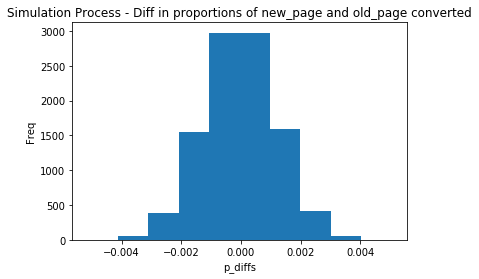

In [313]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution
plt.hist(p_diffs);
plt.xlabel('p_diffs')
plt.ylabel('Freq')
plt.title('Simulation Process - Diff in proportions of new_page and old_page converted');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [314]:
#Get obs_diff
obs_diff = treatment - control
obs_diff

-0.0015782389853555567

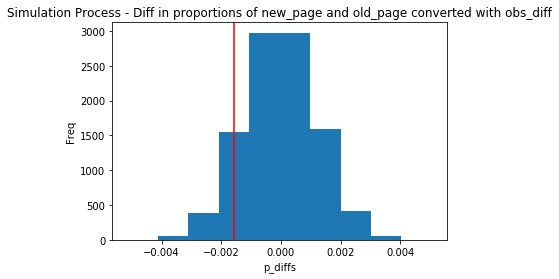

In [315]:
# plot line for observed statistic
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='r')
plt.xlabel('p_diffs')
plt.ylabel('Freq')
plt.title('Simulation Process - Diff in proportions of new_page and old_page converted with obs_diff');

In [316]:
p_diffs

array([-0.00066066, -0.001514  , -0.00172046, ..., -0.00041291,
        0.00106669,  0.00081206])

In [317]:
# computing p-value
(p_diffs > obs_diff).mean()

0.89859999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Conclusion:**

**Null and Alternate Hypothesis:**
$$H_0 : P_{old} >= P_{new}$$
$$H_1 : P_{old} < P_{new}$$

$$ OR $$

$$H_0 : P_{old} - P_{new} >= 0$$
$$H_1 : P_{old} - P_{new} < 0$$


Based on our data, as the p-value (0.90) is significantly higher than our type I error threshold (alpha = 0.05), we fail to reject the null hypothesis. This means, we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

Please note earlier we also saw that the conversion rate for control and treatment groups were almost the same. We also noticed that old page provides a slightly better conversion rate than new page. So, we can keep the old page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [318]:
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
print(convert_old)

convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
print(convert_new)

n_old = len(df2.query('landing_page == "old_page"'))
print(n_old)

n_new = len(df2.query('landing_page == "new_page"'))
print(n_new)

17489
17264
145274
145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [319]:
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

In [320]:
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

If Z score is between -1.96 and +1.96, then p-value will be larger than 0.05, and you cannot reject your null hypothsis. 

As per the data above, z_score is equal to 1.3109, which falls within -1.96 and 1.96. Therefore, we fail to reject the null hypothesis. We can also see that the p value is 0.90 which is significantly higher than our type I error threshold (alpha = 0.05)

Please note: p-value obtained here is similar to the result obtained from previous question (J and K), which also failed to reject the null hypothesis.
This means, we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

Logistic regression is used to predict one of two outcomes, in this case, conversion vs no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [321]:
# create a column for ab_page.
df2[['ab_page_ctrl','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page_ctrl', axis = 1)

# create a column for the intercept
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [322]:
# statsmodels to instantiate regression model on the two columns created
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [323]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:               8.077e-06
Time:                        05:11:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with ab_page is 0.19

The p-value from Part III (0.19) differs significantly from that found in Part II (0.90) because the null and alternate hypothesis also differs as shown below:

Part II:
$$H_0 : P_{old} - P_{new} >= 0$$
$$H_1 : P_{old} - P_{new} < 0$$

Part III:
$$H_0 : P_{old} = P_{new} $$
$$H_1 : P_{old} \neq P_{new} $$

In both cases, even though the p-values are different, we failed to reject the null hypothesis. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to consider other factors (like timestamp) to add into our regression model which will enable us to identify if there is any potential impact on the conversion rate based on these additional factors. Example, we can check if there is any impact on the conversion rate based on the browsing time of each user.

One of the disadavantages of adding additional factors into our regression model is that it can make our model complex and difficult to interpret the model output.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [324]:
# Read in the countries.csv dataset 
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [325]:
# Merge together your datasets (df2) on the appropriate rows with countries df.
df3 = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [326]:
# find out unique countries
df3.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [327]:
# create dummy variables for these country columns
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('CA', axis = 1)

In [328]:
# statsmodels to instantiate regression model on the new columns created
logit_mod1 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK','US']])

In [329]:
results1 = logit_mod1.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:               2.323e-05
Time:                        05:11:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

The p-value for UK and US is larger than 0.05 therefore there is no statistical evidence that country has any significant impact on conversion rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [330]:
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [331]:
#exponentiate to inteprete the result
np.exp(results1.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

Soruce: https://knowledge.udacity.com/questions/221157

In [332]:
#Create a new interaction variable between ab_page and country US and UK
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['US_ab_page'] = df3['US']*df3['ab_page']

In [333]:
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [334]:
# statsmodels to instantiate regression model on the new columns created
logit_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:               3.482e-05
Time:                        05:11:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [335]:
#exponentiate to inteprete the result
np.exp(results2.params)

intercept     0.134794
ab_page       0.934776
UK            1.011854
US            1.017682
UK_ab_page    1.081428
US_ab_page    1.048001
dtype: float64

Source: https://classroom.udacity.com/nanodegrees/nd002/parts/bb0cbeb6-d3f8-4bae-9dc3-4abba3823e54/modules/70ab0502-76fb-425f-880e-e2c73cdbe753/lessons/b7ae43e6-204a-4816-a177-6c75115cae5f/concepts/c5af4b47-e3b7-47fb-8941-a4abfcc6a665

**Summary**

From the above results, we can interpret that other explanatory variables are not statistically significant as the p-value for each one of them is greater than 0.05.

The user getting converted is 1.08 times more likely to happen for 'UK plus ab_page' than 'CA plus ab_page' while holding all other varible constant.

The user getting converted is 1.04 times more likely to happen for 'US plus ab_page' than 'CA plus ab_page' while holding all other varible constant.


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [336]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0